# Get KRX fundamental data

KRX에 있는 funda 데이터 가져옴. 

PER, PBR 있음. 

In [11]:
from pathlib import Path
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import pickle

In [2]:
import FinanceDataReader as fdr
import quantstats as qs

In [10]:
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

In [5]:
## custom libs

from korquanttools.pricevolume.loader import KRXPriceDM
from korquanttools.pricevolume.utils import DateUtil
from korquanttools.pricevolume.config import PathConfig

In [158]:
# Global parameters

START = 20140101
END = 20221202

WINDOW = 60 # trading day 기준

In [159]:
## stock return
return_df = pd.read_pickle(PathConfig.cache_path / f"temp_return_{START}_{END}")

In [160]:
holidays = return_df.isnull().all(axis=1)
tradingdays = ~holidays

holidays = holidays.index[holidays]
tradingdays = tradingdays.index[tradingdays]

tradingdays

DatetimeIndex(['2014-01-02', '2014-01-03', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-13',
               '2014-01-14', '2014-01-15',
               ...
               '2022-11-21', '2022-11-22', '2022-11-23', '2022-11-24',
               '2022-11-25', '2022-11-28', '2022-11-29', '2022-11-30',
               '2022-12-01', '2022-12-02'],
              dtype='datetime64[ns]', name='trdDd', length=2190, freq=None)

In [161]:
return_df = return_df.loc[tradingdays, :].copy()

In [162]:
request_url="http://data.krx.co.kr/comm/bldAttendant/getJsonData.cmd"

In [163]:
# Get funda data
request_headers={
    "Accept": "application/json, text/javascript, */*; q=0.01",
    "Accept-Encoding": "gzip, deflate",
    "Accept-Language": "en-US,en;q=0.9,ko-KR;q=0.8,ko;q=0.7,ja;q=0.6",
    "Connection": "keep-alive",
    "Content-Length": "98",
    "Content-Type": "application/x-www-form-urlencoded; charset=UTF-8",
    # "Cookie": "__smVisitorID=MOg5nSVvce5; JSESSIONID=Zm2tghqTUaVeWZwBoqGf5XDEl5p1ay0OKwMa1bMRQnDGQJ8xpyLTaXTZyGHWcjVY.bWRjX2RvbWFpbi9tZGNvd2FwMi1tZGNhcHAxMQ==",
    "Host": "data.krx.co.kr",
    "Origin": "http://data.krx.co.kr",
    "Referer": "http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201020101",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/95.0.4638.54 Safari/537.36",
    "X-Requested-With": "XMLHttpRequest",
    }

In [164]:
retry_strategy={
    "total": 10,
    "status_forcelist": [413, 429, 500, 502, 503, 504],
    "allowed_methods": ["GET", "POST"],
    "backoff_factor": 2,
    }

In [165]:
POST_data={
    "bld": "dbms/MDC/STAT/standard/MDCSTAT03502",
    "mktId": "ALL", # KOSPI: "STK", KOSDAQ: "KSQ", KONEX: "KNX"
    # "trdDd": None, # format like: "20211029"
    "isuCd": None,
    "strtDd": f"{START}",
    "endDd": f"{END}",
    }

In [166]:
session = requests.session()
assert_status_hook = lambda response, *args, **kwargs: response.raise_for_status()
session.hooks["response"] = [assert_status_hook]
retry_strategy = Retry(**retry_strategy)
adapter = HTTPAdapter(max_retries=retry_strategy)
session.mount("http://", adapter)
session.mount("https://", adapter)

In [167]:
POST_data["isuCd"] = "KR7060310000" # 060310 3S

In [168]:
POST_data["isuCd"] = "KR7005930003" # 005930 삼성전자

데이터를 가져오려면 주식의 short code가 아닌 full code가 필요함. 

In [169]:
response = session.post(
    request_url,
    data=POST_data,
    headers=request_headers
)

In [170]:
funda_df = pd.DataFrame(response.json()['output'])
funda_df

,TRD_DD,TDD_CLSPRC,FLUC_TP_CD,CMPPREVDD_PRC,FLUC_RT,EPS,PER,FWD_EPS,FWD_PER,BPS,PBR,DPS,DVD_YLD
0,2022/12/02,"60,400",2,"-2,200",-3.51,"5,777",10.46,"3,935",15.35,"43,611",1.38,"1,444",2.39
1,2022/12/01,"62,600",1,400,0.64,"5,777",10.84,"4,064",15.40,"43,611",1.44,"1,444",2.31
2,2022/11/30,"62,200",1,"1,600",2.64,"5,777",10.77,"4,064",15.30,"43,611",1.43,"1,444",2.32
3,2022/11/29,"60,600",1,500,0.83,"5,777",10.49,"4,080",14.85,"43,611",1.39,"1,444",2.38
4,2022/11/28,"60,100",2,-900,-1.48,"5,777",10.40,"4,080",14.73,"43,611",1.38,"1,444",2.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2190,2014/01/08,"1,291,000",2,"-13,000",-1.00,"154,020",8.38,-,-,"688,251",1.88,"8,000",0.62
2191,2014/01/07,"1,304,000",2,"-3,000",-0.23,"154,020",8.47,-,-,"688,251",1.89,"8,000",0.61
2192,2014/01/06,"1,307,000",1,"11,000",0.85,"154,020",8.49,-,-,"688,251",1.90,"8,000",0.61
2193,2014/01/03,"1,296,000",2,"-13,000",-0.99,"154,020",8.41,-,-,"688,251",1.88,"8,000",0.62


주식의 full code부터 short code와 mapping 시키고 불러오는 것이 가능. 

In [171]:
# full code를 얻기 위한 POST 데이터
list_POST_data = {
    'bld': 'dbms/comm/finder/finder_stkisu',
    'locale': 'ko_KR',
    'mktsel': 'ALL',
}

In [172]:
response = session.post(
    request_url,
    data=list_POST_data,
    headers=request_headers
)

In [173]:
code_info_df = pd.DataFrame(response.json()['block1'])

In [174]:
code_info_df

,full_code,short_code,codeName,marketCode,marketName,marketEngName,ord1,ord2
0,KR7060310000,060310,3S,KSQ,코스닥,KOSDAQ,,16
1,KR7095570008,095570,AJ네트웍스,STK,유가증권,KOSPI,,16
2,KR7006840003,006840,AK홀딩스,STK,유가증권,KOSPI,,16
3,KR7054620000,054620,APS홀딩스,KSQ,코스닥,KOSDAQ,,16
4,KR7265520007,265520,AP시스템,KSQ,코스닥,KOSDAQ,,16
...,...,...,...,...,...,...,...,...
2676,KR7000542001,000547,흥국화재2우B,STK,유가증권,KOSPI,,16
2677,KR7000541003,000545,흥국화재우,STK,유가증권,KOSPI,,16
2678,KR7003280005,003280,흥아해운,STK,유가증권,KOSPI,,16
2679,KR7037440005,037440,희림,KSQ,코스닥,KOSDAQ,,16


In [175]:
short2full_mapper = dict(zip(code_info_df['short_code'], code_info_df['full_code']))

In [176]:
samsung_electronics_sid = '005930'
short2full_mapper[samsung_electronics_sid]

'KR7005930003'

http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201010105

`FLUC_TP_CD` 는 상승/하락/동일 나타내기 위한 flag로 보임. (색깔 표시를 위해)

`FWD_` 들은 어떤 종목의 경우 존재하나 어떤 종목의 경우 존재하지 않음. 

커버리지에서 차이가 날 것임. 


In [177]:
funda_df.columns

Index(['TRD_DD', 'TDD_CLSPRC', 'FLUC_TP_CD', 'CMPPREVDD_PRC', 'FLUC_RT', 'EPS',
       'PER', 'FWD_EPS', 'FWD_PER', 'BPS', 'PBR', 'DPS', 'DVD_YLD'],
      dtype='object')

In [178]:
def get_KRX_funda(sid, funda_name, start, end):
    funda_name = funda_name.upper()
    assert funda_name in [
        'EPS', 
        'PER', 
        'FWD_EPS', # 선행
        'FWD_PER', # 선행
        'BPS', 
        'PBR', 
        'DPS', # 주당 배당금
        'DVD_YLD', # 배당 수익률
        ]

    start = str(start)
    end = str(end)

    full_sid = short2full_mapper[sid]

    POST_data={
        "bld": "dbms/MDC/STAT/standard/MDCSTAT03502",
        "mktId": "ALL", # KOSPI: "STK", KOSDAQ: "KSQ", KONEX: "KNX"
        # "trdDd": None, # format like: "20211029"
        "isuCd": full_sid,
        "strtDd": start,
        "endDd": end,
        }

    response = session.post(
        request_url, # global param
        data=POST_data,
        headers=request_headers # global param
        )

    funda_df = pd.DataFrame(response.json()['output'])
    funda_df['TRD_DD'] = pd.to_datetime(funda_df['TRD_DD'], format='%Y/%m/%d')
    funda_df.set_index('TRD_DD', inplace=True)
    funda_df.sort_index(ascending=True, inplace=True)

    return funda_df[funda_name].copy()
    
    

In [179]:
funda_df = return_df.copy()
for col in funda_df.columns:
    funda_df[col].values[:] = None

## Above is much faster than:
# funda_df[:] = None

In [181]:
get_KRX_funda(samsung_electronics_sid, 'PBR', START, END)

TRD_DD
2014-01-02    1.90
2014-01-03    1.88
2014-01-06    1.90
2014-01-07    1.89
2014-01-08    1.88
              ... 
2022-11-28    1.38
2022-11-29    1.39
2022-11-30    1.43
2022-12-01    1.44
2022-12-02    1.38
Name: PBR, Length: 2195, dtype: object

In [182]:
get_KRX_funda('000020', 'PBR', START, END)

TRD_DD
2014-01-02    0.55
2014-01-03    0.56
2014-01-06    0.56
2014-01-07    0.56
2014-01-08    0.58
              ... 
2022-11-28    0.70
2022-11-29    0.71
2022-11-30    0.72
2022-12-01    0.74
2022-12-02    0.74
Name: PBR, Length: 2195, dtype: object

Mapping 되지 않는 종목들은 모두 NaN 처리

In [188]:
# 1시간 30분 걸림

for ii in tqdm(funda_df.columns):
    try:
        temp_s = get_KRX_funda(ii, 'PBR', START, END)
        funda_df.loc[:, ii] = temp_s
    except:
        funda_df.loc[:, ii] = None

100%|██████████| 3110/3110 [1:30:49<00:00,  1.75s/it]  


In [207]:
funda_df = funda_df.apply((lambda column: pd.to_numeric(column, errors='coerce')), axis=1)

In [209]:
funda_df.to_pickle(f'temp_KRX_PBR_{START}_{END}.pkl')

In [210]:
funda_df = pd.read_pickle(f'temp_KRX_PBR_{START}_{END}.pkl')

<AxesSubplot:>

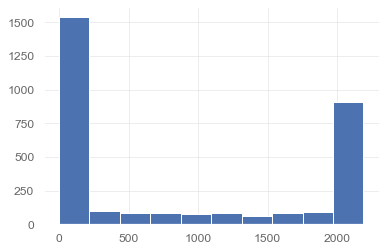

In [211]:
funda_df.isnull().sum(axis=0).hist()

In [212]:
funda_df.isnull().all(axis=0).sum()

812

In [213]:
len(funda_df.columns)

3110